<h1>Assesment Question:</h1>
<p>1- How are blood donations in Malaysia / states trending?</p>
<p>2- How well is Malaysia retaining blood donors? (meaning, are people with a history of blood donation coming back to donate regularly)</p>

And after creating data visualisation for answering this questions, we will need to use Telegram bot API to post a message in a group daily

Question in mind:
1. What visualisation that are useful for daily updates? Or is it sufficient enough to use a visualisation 

In [131]:
from git import Repo
import os
import requests

import pandas as pd 
import numpy as np 
import pyarrow.parquet as pq
import matplotlib.ticker as ticker
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt 
import plotly.graph_objects as go
import seaborn as sns

import geopandas as gpd
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

<h1>Question 1</h1>
<p>Planning:</p>
<p>1. Choropleth on Donation Distribtion for every State</p>
<p>2. Sankey Diagram 3 Level (State->Hospital->Type of Blood)</p>
<p>3. Time-Series Plot of Average Daily per month for each blood type</p>
<p>4. Chart that shows trend on Age</p>

Mainly I Will use data from donations_facility.csv . Since Data of Newdonors are in Age, we can create extra visualisation to show age trend

In [132]:
facility_df = pd.read_csv('.\data_aggregate\donations_facility.csv')
facility_df.head(5)

,date,hospital,daily,blood_a,blood_b,blood_o,blood_ab,location_centre,location_mobile,type_wholeblood,type_apheresis_platelet,type_apheresis_plasma,type_other,social_civilian,social_student,social_policearmy,donations_new,donations_regular,donations_irregular
0,2006-01-01,Hospital Sultanah Nora Ismail,87,19,20,45,3,87,0,87,0,0,0,86,1,0,36,49,2
1,2006-01-01,Hospital Sultanah Aminah,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2006-01-01,Hospital Sultanah Bahiyah,208,67,62,61,18,208,0,208,0,0,0,197,8,3,1,207,0
3,2006-01-01,Hospital Raja Perempuan Zainab II,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2006-01-01,Hospital Melaka,1,0,0,1,0,1,0,1,0,0,0,1,0,0,0,1,0


In [133]:
#getting the list of facilities
list(facility_df['hospital'].unique())

['Hospital Sultanah Nora Ismail',
 'Hospital Sultanah Aminah',
 'Hospital Sultanah Bahiyah',
 'Hospital Raja Perempuan Zainab II',
 'Hospital Melaka',
 'Hospital Tuanku Jaafar',
 'Hospital Tengku Ampuan Afzan',
 'Hospital Sultan Haji Ahmad Shah',
 'Hospital Seberang Jaya',
 'Hospital Pulau Pinang',
 'Hospital Raja Permaisuri Bainun',
 'Hospital Taiping',
 'Hospital Seri Manjung',
 'Hospital Tengku Ampuan Rahimah',
 'Hospital Sultanah Nur Zahirah',
 'Hospital Queen Elizabeth II',
 'Hospital Duchess Of Kent',
 'Hospital Tawau',
 'Hospital Umum Sarawak',
 'Hospital Miri',
 'Hospital Sibu',
 'Pusat Darah Negara']

In [134]:
# Manually Map the list of hospital to their state
hospital_state = {
    'Hospital Sultanah Nora Ismail': 'Johor',
    'Hospital Sultanah Aminah': 'Johor',
    'Hospital Sultanah Bahiyah': 'Kedah',
    'Hospital Raja Perempuan Zainab II': 'Kelantan',
    'Hospital Melaka': 'Melaka',
    'Hospital Tuanku Jaafar': 'Negeri Sembilan',
    'Hospital Tengku Ampuan Afzan': 'Pahang',
    'Hospital Sultan Haji Ahmad Shah': 'Pahang',
    'Hospital Seberang Jaya': 'Penang',
    'Hospital Pulau Pinang': 'Penang',
    'Hospital Raja Permaisuri Bainun': 'Perak',
    'Hospital Taiping': 'Perak',
    'Hospital Seri Manjung': 'Perak',
    'Hospital Tengku Ampuan Rahimah': 'Selangor',
    'Hospital Sultanah Nur Zahirah': 'Terengganu',
    'Hospital Queen Elizabeth II': 'Sabah',
    'Hospital Duchess Of Kent': 'Sabah',
    'Hospital Tawau': 'Sabah',
    'Hospital Umum Sarawak': 'Sarawak',
    'Hospital Miri': 'Sarawak',
    'Hospital Sibu': 'Sarawak',
    'Pusat Darah Negara': 'Kuala Lumpur'
}

#Add another column to the dataframe
facility_df['state'] = facility_df['hospital'].map(hospital_state)
facility_df

,date,hospital,daily,blood_a,blood_b,blood_o,blood_ab,location_centre,location_mobile,type_wholeblood,type_apheresis_platelet,type_apheresis_plasma,type_other,social_civilian,social_student,social_policearmy,donations_new,donations_regular,donations_irregular,state
0,2006-01-01,Hospital Sultanah Nora Ismail,87,19,20,45,3,87,0,87,0,0,0,86,1,0,36,49,2,Johor
1,2006-01-01,Hospital Sultanah Aminah,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Johor
2,2006-01-01,Hospital Sultanah Bahiyah,208,67,62,61,18,208,0,208,0,0,0,197,8,3,1,207,0,Kedah
3,2006-01-01,Hospital Raja Perempuan Zainab II,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Kelantan
4,2006-01-01,Hospital Melaka,1,0,0,1,0,1,0,1,0,0,0,1,0,0,0,1,0,Melaka
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145173,2024-01-25,Hospital Tawau,19,6,2,11,0,2,17,19,0,0,0,19,0,0,1,18,0,Sabah
145174,2024-01-25,Hospital Umum Sarawak,72,11,22,34,5,39,33,72,0,0,0,68,3,1,13,43,16,Sarawak
145175,2024-01-25,Hospital Miri,4,1,2,1,0,4,0,4,0,0,0,4,0,0,0,4,0,Sarawak
145176,2024-01-25,Hospital Sibu,30,7,10,13,0,8,22,30,0,0,0,24,6,0,18,9,3,Sarawak


In [135]:
#Filter the data by last 3 months
facility_df['date']= pd.to_datetime(facility_df['date']) # set the column data type into pandas datetime
latest_date = max(facility_df['date']) #Get the latest date in the dataframe
last_3_months = latest_date-pd.Timedelta(days=90) #Get the date 3 months ago
last3_df = facility_df[facility_df['date']>=last_3_months] #Filter the data by last 3 months
last3_df

,date,hospital,daily,blood_a,blood_b,blood_o,blood_ab,location_centre,location_mobile,type_wholeblood,type_apheresis_platelet,type_apheresis_plasma,type_other,social_civilian,social_student,social_policearmy,donations_new,donations_regular,donations_irregular,state
143176,2023-10-27,Hospital Sultanah Nora Ismail,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Johor
143177,2023-10-27,Hospital Sultanah Aminah,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Johor
143178,2023-10-27,Hospital Sultanah Bahiyah,101,25,27,43,6,0,101,101,0,0,0,100,1,0,4,89,8,Kedah
143179,2023-10-27,Hospital Raja Perempuan Zainab II,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Kelantan
143180,2023-10-27,Hospital Melaka,95,24,30,31,10,8,87,95,0,0,0,91,3,1,19,53,23,Melaka
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145173,2024-01-25,Hospital Tawau,19,6,2,11,0,2,17,19,0,0,0,19,0,0,1,18,0,Sabah
145174,2024-01-25,Hospital Umum Sarawak,72,11,22,34,5,39,33,72,0,0,0,68,3,1,13,43,16,Sarawak
145175,2024-01-25,Hospital Miri,4,1,2,1,0,4,0,4,0,0,0,4,0,0,0,4,0,Sarawak
145176,2024-01-25,Hospital Sibu,30,7,10,13,0,8,22,30,0,0,0,24,6,0,18,9,3,Sarawak


In [136]:
#group by state
state3_df = last3_df.groupby('state')['daily'].sum().reset_index(name='total_donation')
state3_df

,state,total_donation
0,Johor,11436
1,Kedah,5370
2,Kelantan,4343
3,Kuala Lumpur,50474
4,Melaka,6806
5,Negeri Sembilan,4326
6,Pahang,5506
7,Penang,9635
8,Perak,10974
9,Sabah,10185


From the dataset of MOH, It seems there are no data for blood donation in Perlis.

To do Choropleth, we need to use polygon data to get the boundary of each state in the dataset,
I found the polygon data with this link https://cartographyvectors.com/map/1477-malaysia-with-regions

In [137]:
#read geojson file
gdf = gpd.read_file('malaysia-with-regions_.geojson')
gdf.head()

,id,name,density,path,geometry
0,5871,Federal Territory of Kuala Lumpur,0,/world/Malaysia/Federal Territory of Kuala Lumpur,"MULTIPOLYGON (((101.63830 3.22810, 101.66559 3..."
1,5874,Federal Territory of Putrajaya,0,/world/Malaysia/Federal Territory of Putrajaya,"MULTIPOLYGON (((101.67933 2.97116, 101.68001 2..."
2,5878,Johor,0,/world/Malaysia/Johor,"MULTIPOLYGON (((103.63678 2.65774, 103.65669 2..."
3,5875,Kedah,0,/world/Malaysia/Kedah,"MULTIPOLYGON (((100.33882 5.57806, 100.33058 5..."
4,5879,Kelantan,0,/world/Malaysia/Kelantan,"MULTIPOLYGON (((102.09183 6.23886, 102.16461 6..."


In [138]:
# We need to process the geospatial data so we can merge it with the donations dataset
gdf.drop(columns=['id','density','path'],axis=1,inplace=True)#drop col
gdf.drop(index=[1,10],inplace=True)#drop Perlis and Putrajaya
gdf.loc[0,'name'] = 'Kuala Lumpur' #rename Wilayah KL to Kuala Lumpur
gdf.sort_values(by='name',inplace=True) #Sort by name
gdf.reset_index(inplace=True,drop=True)#reset index
gdf.head()

,name,geometry
0,Johor,"MULTIPOLYGON (((103.63678 2.65774, 103.65669 2..."
1,Kedah,"MULTIPOLYGON (((100.33882 5.57806, 100.33058 5..."
2,Kelantan,"MULTIPOLYGON (((102.09183 6.23886, 102.16461 6..."
3,Kuala Lumpur,"MULTIPOLYGON (((101.63830 3.22810, 101.66559 3..."
4,Melaka,"MULTIPOLYGON (((102.48837 2.09912, 102.47412 2..."


In [139]:
#Merging with the donations dataset
state3_df_merged = gdf.merge(state3_df, how='left', left_on='name', right_on='state')
state3_df_merged=state3_df_merged.iloc[:,1:]
state3_df_merged

,geometry,state,total_donation
0,"MULTIPOLYGON (((103.63678 2.65774, 103.65669 2...",Johor,11436
1,"MULTIPOLYGON (((100.33882 5.57806, 100.33058 5...",Kedah,5370
2,"MULTIPOLYGON (((102.09183 6.23886, 102.16461 6...",Kelantan,4343
3,"MULTIPOLYGON (((101.63830 3.22810, 101.66559 3...",Kuala Lumpur,50474
4,"MULTIPOLYGON (((102.48837 2.09912, 102.47412 2...",Melaka,6806
5,"MULTIPOLYGON (((101.97475 2.38986, 101.97166 2...",Negeri Sembilan,4326
6,"MULTIPOLYGON (((103.42117 4.17557, 103.40195 4...",Pahang,5506
7,"MULTIPOLYGON (((100.39513 5.12685, 100.42602 5...",Penang,9635
8,"MULTIPOLYGON (((100.81535 3.84987, 100.76111 3...",Perak,10974
9,"MULTIPOLYGON (((115.40588 4.96509, 115.55420 5...",Sabah,10185


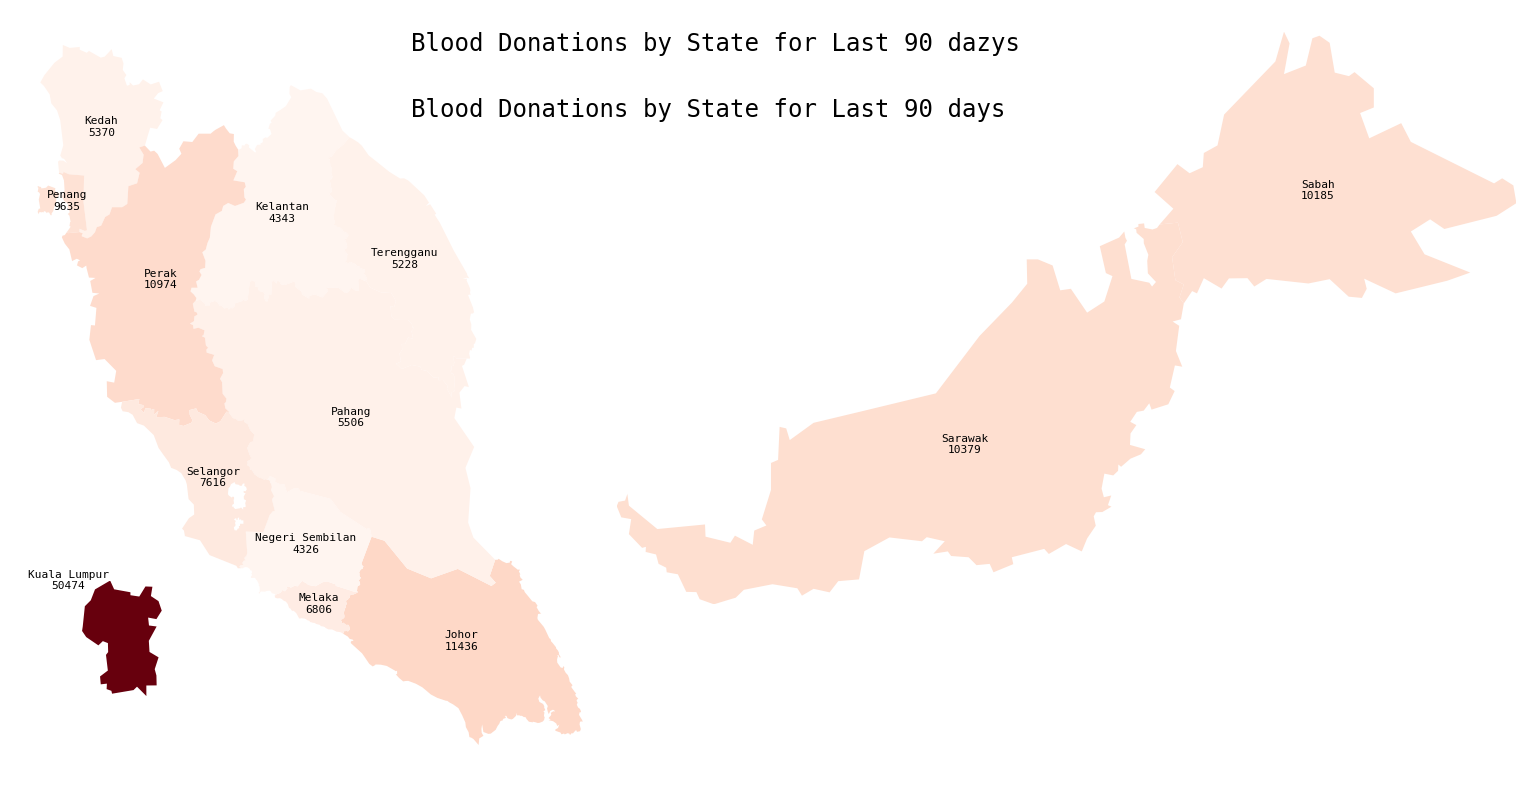

In [140]:
# Normalize Total Donation 
vmin, vmax = state3_df_merged['total_donation'].min(), state3_df_merged['total_donation'].max()
norm = Normalize(vmin=vmin, vmax=vmax)
colour_gradient = 'Reds'

# Create the main plot for Peninsular Malaysia excluding Kuala Lumpur for clarity
fig, ax_main = plt.subplots(figsize=(10, 10))
plt.text(x=103,y=6,s = 'Blood Donations by State for Last 90 days',fontsize = 'xx-large')
plt.text(x=103,y=6.5,s = 'Blood Donations by State for Last 90 dazys',fontsize = 'xx-large')
peninsular_without_kl = state3_df_merged[(state3_df_merged['state'] != 'Sabah') & (state3_df_merged['state'] != 'Sarawak') & (state3_df_merged['state'] != 'Kuala Lumpur')]
peninsular_without_kl.plot(column='total_donation', ax=ax_main, cmap=colour_gradient, norm=norm)

# Create an inset for Sabah and Sarawak
ax_sabah_sarawak = inset_axes(ax_main, width="150%", height="150%", loc='center left',
                               bbox_to_anchor=(1, 0.1, 1, 1), bbox_transform=ax_main.transAxes)
sabah_sarawak = state3_df_merged[(state3_df_merged['state'] == 'Sabah') | (state3_df_merged['state'] == 'Sarawak')]
sabah_sarawak.plot(column='total_donation', ax=ax_sabah_sarawak, cmap=colour_gradient,norm=norm)

# Adjust Sabah and Sarawak plot (optional zoom and removing axis)
ax_sabah_sarawak.set_xlim([sabah_sarawak.total_bounds[0], sabah_sarawak.total_bounds[2]])
ax_sabah_sarawak.set_ylim([sabah_sarawak.total_bounds[1], sabah_sarawak.total_bounds[3]])
ax_sabah_sarawak.set_frame_on(False)
ax_sabah_sarawak.set_xticks([])
ax_sabah_sarawak.set_yticks([])

# Create an inset for Kuala Lumpur
ax_kl = inset_axes(ax_main, width="15%", height="15%", loc='lower left',
                    bbox_to_anchor=(0.1, 0.1, 1, 1), bbox_transform=ax_main.transAxes)
kl = state3_df_merged[state3_df_merged['state'] == 'Kuala Lumpur']
kl.plot(column='total_donation', ax=ax_kl, cmap=colour_gradient,norm=norm)

# Adjust Kuala Lumpur plot (optional zoom and removing axis)
ax_kl.set_xlim([kl.total_bounds[0], kl.total_bounds[2]])
ax_kl.set_ylim([kl.total_bounds[1], kl.total_bounds[3]])
ax_kl.set_frame_on(False)
ax_kl.set_xticks([])
ax_kl.set_yticks([])

# Remove axis for the main plot for a cleaner look
ax_main.set_axis_off()

# Add Label to the plot
for idx, row in state3_df_merged.iterrows():
    
    # Get the position of the label
    x, y = row['geometry'].centroid.x, row['geometry'].centroid.y
    
    # Define the label text
    label_text = f"{row['state']}\n{row['total_donation']}"
    # Place the label on the map
    if row['state'] == 'Kuala Lumpur':
        ax_kl.text(x-0.1, y+0.1, label_text, fontsize=8, ha='center', va='center',color='black')
    
    elif (row['state'] == 'Sarawak') | (row['state'] == 'Sabah'):
        ax_sabah_sarawak.text(x, y, label_text, fontsize=8, ha='center', va='center')
    
    else:
        ax_main.text(x, y, label_text, fontsize=8, ha='center', va='center')

# Add title to the main plot


# Show the map
plt.show()

The data only shows blood donations but does not present the stocks of the blood itself

In [141]:
#now prepare data for Sankey
today_df = facility_df[facility_df['date']==latest_date][['hospital','state','blood_a','blood_b','blood_o','blood_ab']]
# Melt the data to transform blood type columns into rows
melted_data = today_df.melt(id_vars=['state', 'hospital'], value_vars=['blood_a', 'blood_b', 'blood_o', 'blood_ab'], 
                        var_name='blood_type', value_name='donations')

# Replace blood type column names with just the blood type
melted_data['blood_type'] = melted_data['blood_type'].str.replace('blood_', '')

# Creating a list of unique states, hospitals, and blood types to define nodes
states = list(melted_data['state'].unique())
hospitals = list(melted_data['hospital'].unique())
blood_types = list(melted_data['blood_type'].unique())
all_nodes = states + hospitals + blood_types

# # Create a mapping from node names to indices
node_indices = {node: idx for idx, node in enumerate(all_nodes)}
# Map the states, hospitals, and blood types to their respective indices
melted_data['source_state_to_hospital'] = melted_data['state'].map(node_indices)
melted_data['target_hospital_to_blood'] = melted_data['hospital'].map(node_indices)
melted_data['target_blood'] = melted_data['blood_type'].map(node_indices)

# Create two sets of links: one from state to hospital and another from hospital to blood type
links_state_to_hospital = melted_data[['source_state_to_hospital', 'target_hospital_to_blood', 'donations']]
links_hospital_to_blood = melted_data[['target_hospital_to_blood', 'target_blood', 'donations']]

# Combine the links into a single dataframe
links_combined = pd.concat([
    links_state_to_hospital.rename(columns={'source_state_to_hospital': 'source', 'target_hospital_to_blood': 'target'}),
    links_hospital_to_blood.rename(columns={'target_hospital_to_blood': 'source', 'target_blood': 'target'})
])

# Sum the donation counts for each link
links_summed = links_combined.groupby(['source', 'target']).sum().reset_index()

# Create the Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 10,
      line = dict(color = "black", width = 0.5),
      label = all_nodes
    ),
    link = dict(
      source = links_summed['source'],
      target = links_summed['target'],
      value = links_summed['donations']
    ))])

fig.update_layout(title_text=f"State to Hospital to Blood Type Donations for the latest date ({latest_date.date()})", font_size=10)
fig.show()


Since sankey Chart shows almost similar insight to the choropleth, we will decide to move on with another visualisation

C:\Users\DataMicron\AppData\Local\Temp\ipykernel_26300\4160263007.py:9: FutureWarning:

last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead

C:\Users\DataMicron\AppData\Local\Temp\ipykernel_26300\4160263007.py:9: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



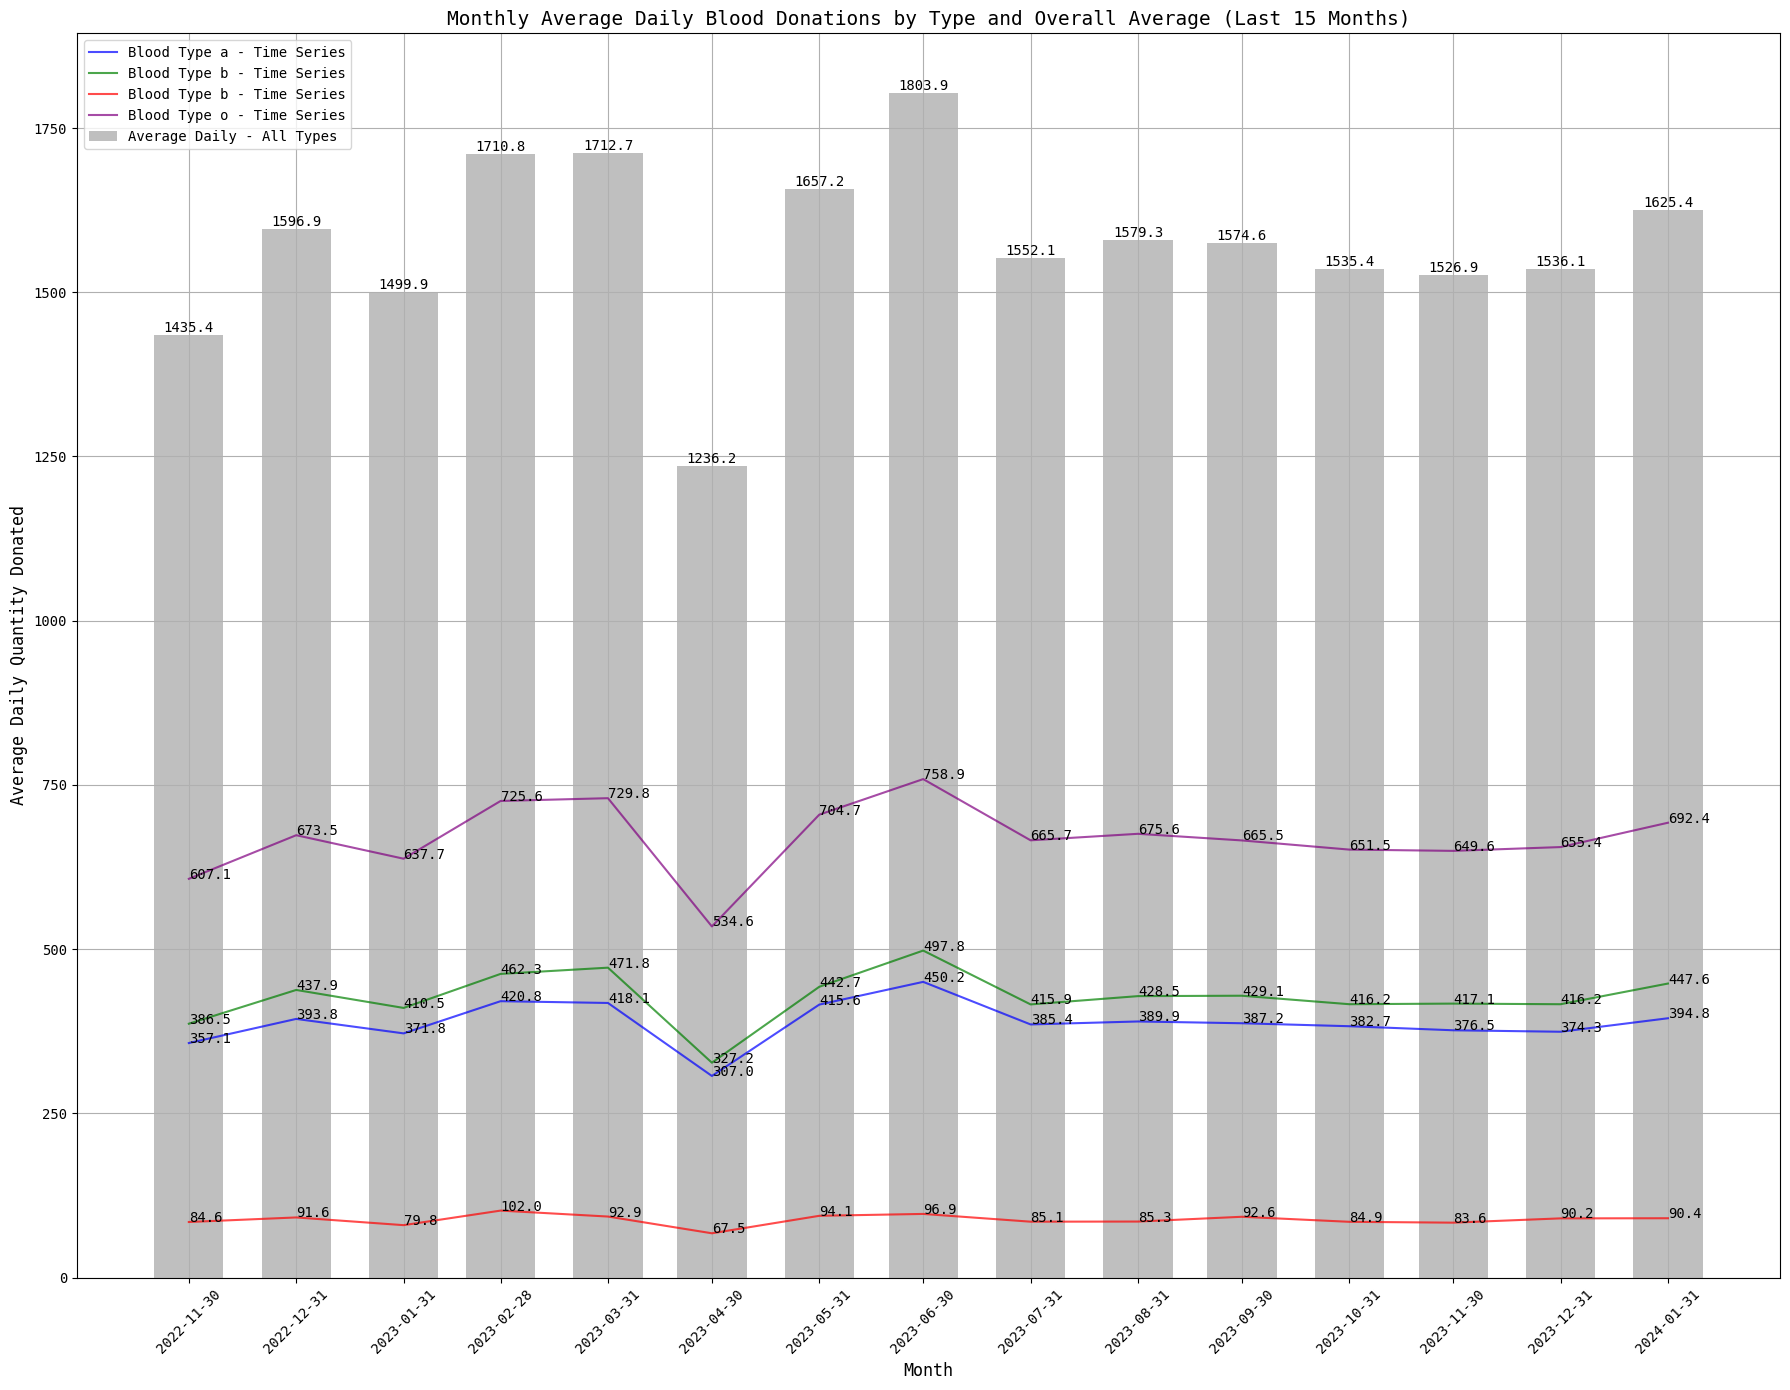

In [142]:
#Prepare to plot Time Series
# Grouping data by date
aggregated_data = facility_df.groupby('date')[['blood_a', 'blood_b', 'blood_ab', 'blood_o','daily']].sum()

# Resampling the data to a monthly frequency and calculating the average daily donations for each blood type
average_daily_per_month = aggregated_data.resample('ME').mean()

# Selecting the last 15 months for comparison
last_15_months_avg_daily = average_daily_per_month.last('15M')

# Setting the style for the plot
plt.rcParams.update({'font.family':'monospace'})

# Creating a larger figure
plt.figure(figsize=(18, 14))

# Time Series Plot for each blood type with data labels
for blood_type, color in zip(['blood_a', 'blood_b', 'blood_ab', 'blood_o'], ['blue', 'green', 'red', 'purple']):
    plt.plot(last_15_months_avg_daily.index, last_15_months_avg_daily[blood_type], label=f'Blood Type {blood_type[-1]} - Time Series', color=color, alpha=0.7)
    for x, y in zip(last_15_months_avg_daily.index, last_15_months_avg_daily[blood_type]):
        plt.text(x, y, f'{y:.1f}', color='black', fontsize=10)

# Bar Chart Overlay for average daily donation of all types with data labels
bar_width = 20  # days
bars = plt.bar(last_15_months_avg_daily.index, last_15_months_avg_daily['daily'], width=bar_width, label='Average Daily - All Types', color='grey', alpha=0.5)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.1f}', va='bottom', ha='center', fontsize=10)

plt.title('Monthly Average Daily Blood Donations by Type and Overall Average (Last 15 Months)', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Average Daily Quantity Donated', fontsize=12)
plt.xticks(last_15_months_avg_daily.index, rotation=45, fontsize=10)
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

<h1>Question 2</h1>
<p>Planning:</p>
<p>1. Two level Doughnut Chart Shows The Difference of Someone who Donate once and People Who Donate more than one time and group it to how many times had they donated</p>
<p>2. Horizontal Bar Chart to show the Distribution of Yesterday Donation by group of donation frequency

In [143]:
table = pq.read_table('data_granular\gran_data.parquet')
gran_df = table.to_pandas()

In [144]:
gran_df.head()

,donor_id,visit_date,birth_date
0,00000,2013-11-03,1964
1,00000,2014-05-26,1964
2,00000,2015-01-25,1964
3,00000,2015-08-09,1964
4,00000,2016-03-10,1964


In [145]:
#checking null in the dataset
gran_df.isna().sum()

donor_id      0
visit_date    0
birth_date    0
dtype: int64

Theres no null in the dataset

In [146]:
#Check the number of donator in the database
gran_df['donor_id'].nunique()

2245937

In [147]:
gran_df['visit_date'] = pd.to_datetime(gran_df['visit_date'])

In [148]:
sort_gran = gran_df.sort_values(by=['donor_id','visit_date'])

In [149]:
sort_gran['donor_age'] = sort_gran['visit_date'].dt.year-sort_gran['birth_date']
sort_gran

,donor_id,visit_date,birth_date,donor_age
0,00000,2013-11-03,1964,49
1,00000,2014-05-26,1964,50
2,00000,2015-01-25,1964,51
3,00000,2015-08-09,1964,51
4,00000,2016-03-10,1964,52
...,...,...,...,...
6249694,09qgv,2024-01-25,1984,40
6249698,09qgw,2024-01-25,1992,32
6249699,09qgx,2024-01-25,1997,27
6249703,09qgy,2024-01-25,1997,27


From the age of the donor, we discovered there might be a data entry problem as there are donor who are more thn 100 years old donating the blood.
Thus we will make the rule to only take donor who are from 18 until 65 years old (the max age of eligible to become blood donors) cite from PPUM website.
https://www.ummc.edu.my/pesakit/blood-CRITERIA.asp?kodBM=#:~:text=Age%3A,donor%3A%2018%2D65%20years%20old

In [150]:
#filter the donor age less or equal to 65
sort_gran_fil = sort_gran[sort_gran['donor_age']<=65]
sort_gran_fil


,donor_id,visit_date,birth_date,donor_age
0,00000,2013-11-03,1964,49
1,00000,2014-05-26,1964,50
2,00000,2015-01-25,1964,51
3,00000,2015-08-09,1964,51
4,00000,2016-03-10,1964,52
...,...,...,...,...
6249694,09qgv,2024-01-25,1984,40
6249698,09qgw,2024-01-25,1992,32
6249699,09qgx,2024-01-25,1997,27
6249703,09qgy,2024-01-25,1997,27


To show does Malaysia Retain their blood donater, by looking at the frequency of repeated number of donation.
We generalize all type of donation into blood donation

In [151]:
#group by donor id to get the number of their donations
donor_donations = sort_gran_fil.groupby('donor_id').size().reset_index(name='donation_count')
donor_donations

,donor_id,donation_count
0,00000,11
1,00001,4
2,00002,12
3,00003,5
4,00004,3
...,...,...
2245538,09qgv,1
2245539,09qgw,1
2245540,09qgx,1
2245541,09qgy,1


<Axes: ylabel='Frequency'>

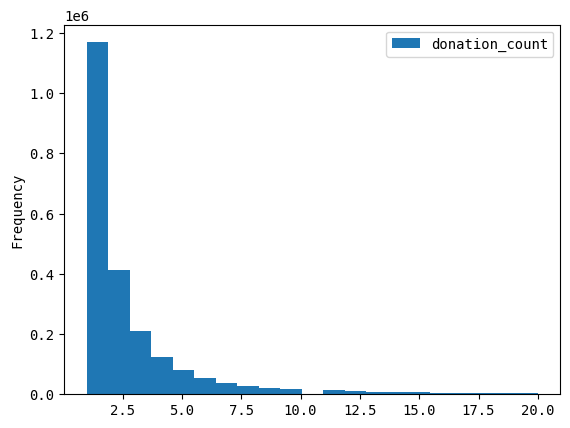

In [152]:
#Plot Histogram for the donation count to see the distribution
donor_donations[donor_donations['donation_count']<=20].plot(kind='hist', bins=21)

Since using histogram does not give much insights except there are a lot of people who are not a repeater for blood donation. Lets try using Pie Chart for two category one time donator and a repeater

In [153]:
#group the donor into repeater or not
repeater = []
for idx,val in enumerate(donor_donations['donation_count']):
    if val > 1:
        repeater.append(True)
    else:
        repeater.append(False)
donor_donations['repeater'] = repeater
donor_donations.head(10)

,donor_id,donation_count,repeater
0,00000,11,True
1,00001,4,True
2,00002,12,True
3,00003,5,True
4,00004,3,True
5,00005,9,True
6,00006,3,True
7,00007,15,True
8,00008,5,True
9,00009,19,True


([<matplotlib.patches.Wedge at 0x2a08a7a2690>,
 [Text(0.21436225097295947, 3.2930303407891355, 'Repeater'),
  Text(-0.2143619426572059, -3.293030360859163, 'One Time')],
 [Text(0.11692486416706878, 1.7961983677031643, '47.93%'),
  Text(-0.11692469599483955, -1.7961983786504523, '52.07%')])

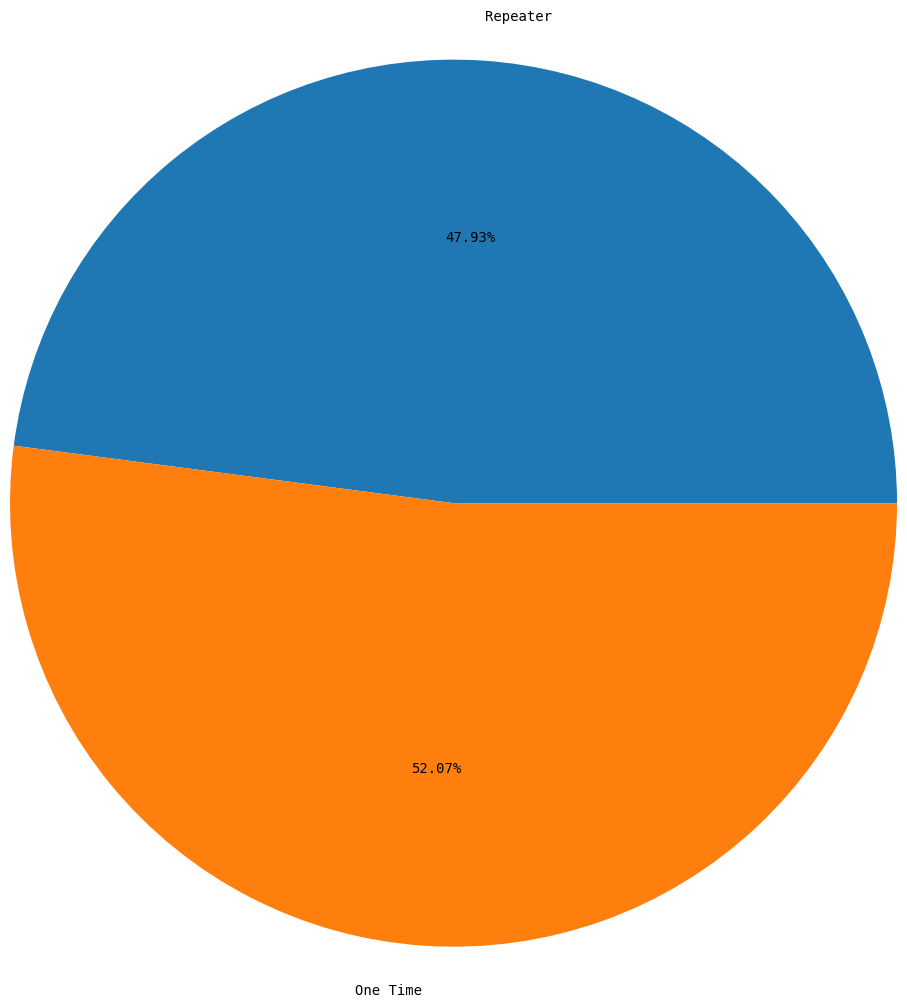

In [154]:
#Plot PieChart for repeater or not
one_time_count = donor_donations[donor_donations['repeater']==False]['repeater'].count()
repeater_count = donor_donations[donor_donations['repeater']==True]['repeater'].count()

fig,ax= plt.subplots()
label = ['Repeater','One Time']
sizes = [repeater_count,one_time_count]
ax.pie(sizes,labels=label,autopct='%1.2f%%',radius=3)


In [155]:
#Banding the donation_count
donor_donations[donor_donations['repeater']==True]['donation_count'].quantile(0.7)
first_group = donor_donations[(donor_donations['donation_count']>=2)&(donor_donations['donation_count']<=3)]['donation_count'].count()
second_group = donor_donations[(donor_donations['donation_count']>=4)&(donor_donations['donation_count']<=7)]['donation_count'].count()
third_group = donor_donations[(donor_donations['donation_count']>=8)]['donation_count'].count()

([<matplotlib.patches.Wedge at 0x2a08a7fa690>,
 [Text(2.1165799096404023, 2.5318154526162897, '2-3'),
  Text(-1.8527567666347333, 2.7308043437216827, '4-7'),
  Text(-3.1073664206598592, 1.1109788151695497, '8+'),
  Text(-0.2143619426572059, -3.293030360859163, '1')],
 [Text(1.1544981325311283, 1.3809902468816124, '27.84%'),
  Text(-1.0105945999825816, 1.4895296420300084, '13.30%'),
  Text(-1.6949271385417413, 0.605988444637936, '6.79%'),
  Text(-0.11692469599483955, -1.7961983786504523, '52.07%')])

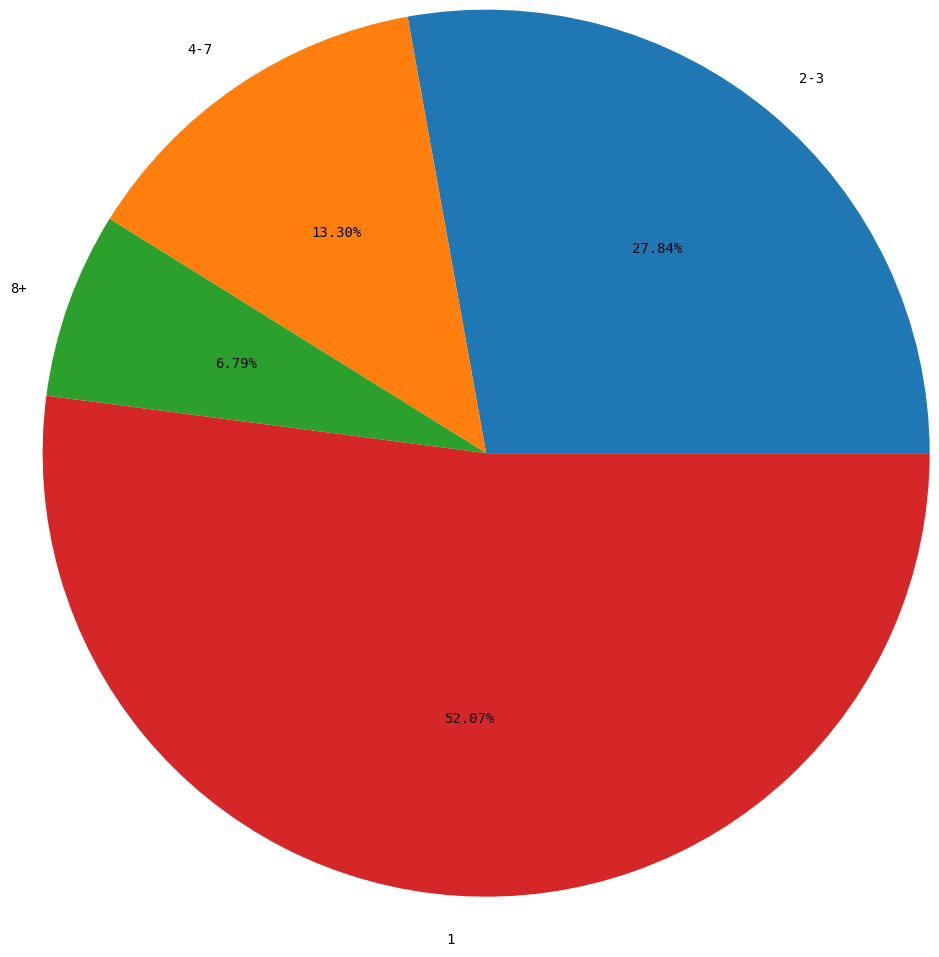

In [156]:
#Pie Chart for the group of Repeater
fig,ax= plt.subplots()
label = ['2-3','4-7','8+','1']
sizes = [first_group,second_group,third_group,one_time_count]
ax.pie(sizes,labels=label,autopct='%1.2f%%',radius=3)

[None, None, None, None]

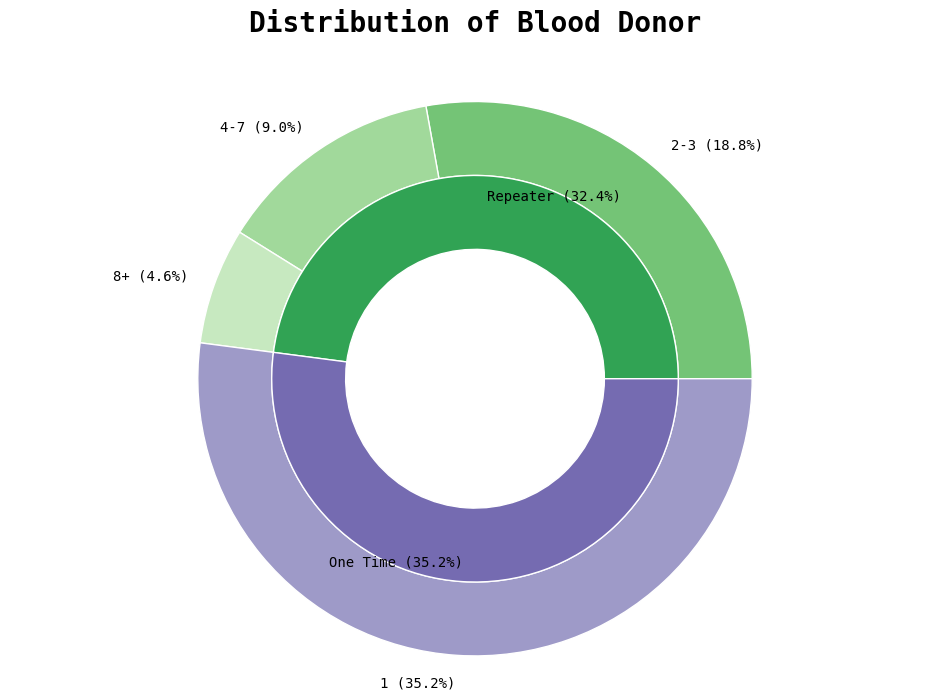

In [166]:
#Plot a two level Pie Chart
fig,ax = plt.subplots(figsize=(12,3))
ax.axis('equal')
width = 0.8

plt.text(0, 4, 'Distribution of Blood Donor', horizontalalignment='center', verticalalignment='top', fontsize=20, weight='bold')

#label and size for outer donut chart
size_out = [first_group,second_group,third_group,one_time_count]
label_out = ['2-3','4-7','8+','1']

#label and size for inner donut chart
label_in = ['Repeater','One Time']
sizes_in = [repeater_count,one_time_count]

# Calculate the total count for the calculation of percentages
total_count = sum(size_out) + sum(sizes_in) - one_time_count  # Subtract one_time_count since it's included twice

# Calculate the percentages for the outer ring
percentages_out = [f"{(size / total_count * 100):.1f}%" for size in size_out]

# Update labels for the outer ring with percentages
label_out_with_perc = [f"{label} ({perc})" for label, perc in zip(label_out, percentages_out)]

# Calculate the percentages for the inner ring
percentages_in = [f"{(size / total_count * 100):.1f}%" for size in sizes_in]

# Update labels for the inner ring with percentages
label_in_with_perc = [f"{label} ({perc})" for label, perc in zip(label_in, percentages_in)]


#Outer Ring (Donation Count Band)
cm = plt.get_cmap("tab20c")

cout = cm(np.array([9,10,11,13]))
pie, _ = ax.pie(size_out, radius=3, labels=label_out_with_perc, colors=cout)
plt.setp(pie, width=width, edgecolor='white',)

#Inner Ring (Repeater Or Not)
cin = cm(np.array([8,12]))
pie2, _ = ax.pie(sizes_in, radius=3-width, labels=label_in_with_perc,
                 labeldistance=0.9, colors=cin,rotatelabels=0)
plt.setp(pie2, width=width, edgecolor='white')

This is a good for a summary report but its not suitable for daily report. I will add for daily data.

In [158]:
#Getting all latest date donor
latest_date = max(sort_gran_fil['visit_date'])
latest_donor = sort_gran_fil[sort_gran_fil['visit_date']==latest_date]


In [162]:
# Merge the two dataframes on 'donor_id'
latest_donor = latest_donor.merge(donor_donations[['donor_id', 'donation_count']], on='donor_id', how='left')

# Rename the 'donation_count' column to 'donations_count'
latest_donor.rename(columns={'donation_count': 'donations_count'}, inplace=True)

# Display the first 10 rows of the updated dataframe
latest_donor.head(10)


,donor_id,visit_date,birth_date,donor_age,donations_count
0,000p3,2024-01-25,1989,35,3
1,000ro,2024-01-25,1983,41,13
2,002Cd,2024-01-25,1985,39,7
3,002R9,2024-01-25,1985,39,3
4,003Nf,2024-01-25,1981,43,3
5,003eo,2024-01-25,1996,28,3
6,005Hq,2024-01-25,1970,54,4
7,005Tb,2024-01-25,1975,49,3
8,005Vb,2024-01-25,1973,51,9
9,0067Q,2024-01-25,1988,36,4


In [163]:
latest_donor[latest_donor['donations_count']== 1]['donations_count'].count()

697

In [164]:
#Banding the donation_count
new_latest = latest_donor[latest_donor['donations_count']== 1]['donations_count'].count()
first_group_latest = latest_donor[(latest_donor['donations_count']>= 2)&(latest_donor['donations_count']<=3)]['donations_count'].count()
second_group_latest = latest_donor[(latest_donor['donations_count']>= 4)&(latest_donor['donations_count']<=7)]['donations_count'].count()
third_group_latest = latest_donor[(latest_donor['donations_count']>=8)]['donations_count'].count()

values = [new_latest,first_group_latest,second_group_latest,third_group_latest]
values
labels_latest = ['New Donator','2-3 Donations','4-7 Donations','8+ Donations']
labels_latest


['New Donator', '2-3 Donations', '4-7 Donations', '8+ Donations']

Text(0, 0.5, 'Group of Donators Based on Frequency')

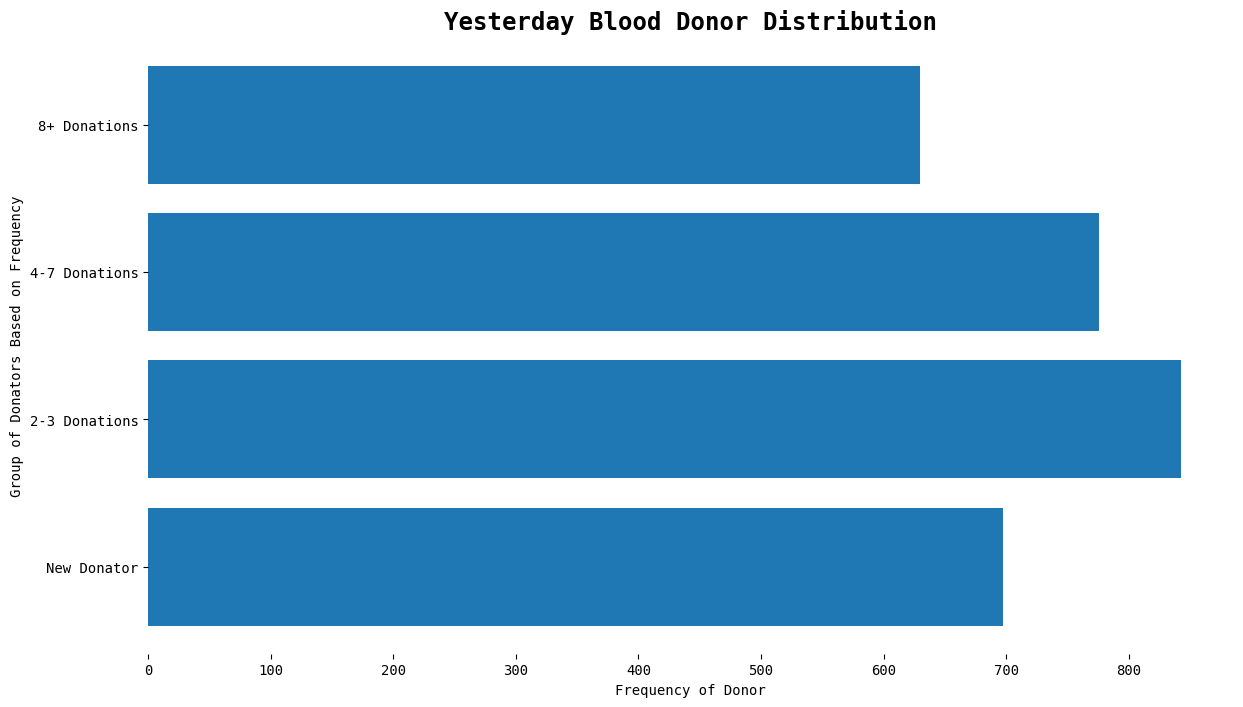

In [179]:
#plot Horizontal Bar for the latest donations frequency
fig,ax = plt.subplots(figsize=(14,8))
plt.barh(labels_latest,values),

plt.title('Yesterday Blood Donor Distribution',weight = 'bold',fontsize = 'xx-large')
ax.set_frame_on(False)
plt.xlabel('Frequency of Donor')
plt.ylabel('Group of Donators Based on Frequency')

In [ ]:
#Banding the age to Age Group with the newdonors csv file as reference

